# TextMining CW2
### Jie Wang &emsp; Rong Jian Yee &emsp; Hao Cao &emsp; Zhiyuan Zhao

### Main Tasks
1. What is the domiant sentiment towards large language models such as OpenAI's ChatGPT and others?
2. What are the pros and cons of these large language models that people have been discussing?
3. What field will large language models be most beneficial and useful in the future?

---

# Data generating

1. using the API search_tweets of version 4.0+ to acquire the data from twitter.
2. convert all tweets from list to dataframe.
3. store the data in csv file.

In [3]:
import tweepy
import pandas as pd
import time

auth = tweepy.OAuthHandler('BcWEliOxF0h6v9VWpUlNtS5nU', 'HfW6WHnnPqB5BkodYKgMTAihGbmEjioJpP3DhAekLLtVeb6xIi')
auth.set_access_token('841021709209731073-rRR8mlOkIw7pLGEnplp03nWwnYOGwJ3', 'Aa2c8dlmUOKzsRRRc0v6gELtKbJFAkcNwNzOe9T6uuCUQ')

api = tweepy.API(auth, wait_on_rate_limit=True) #

# Collect tweets
query = "#chatgpt" + " -filter:retweets"
# cutoff_date = "2023-03-05"
tweets = tweepy.Cursor(api.search_tweets, q=query, lang="en", count=100).items(2000)

tweets_list = [[tweet.created_at, tweet.user.screen_name, tweet.user.location, tweet.text] for tweet in tweets]

tweets_df = pd.DataFrame(data=tweets_list, columns=['date', 'user', 'location', 'text'])

# A good idea to save downloaded tweets as CSV
tweets_df.to_csv ('./resources/chatgpt.csv', quotechar='"', encoding='utf8', index = False, header=True)
print("Finish data generation.")

Rate limit reached. Sleeping for: 603


Finish data generation.


---

# Data cleaning

1. Mainly using the regular expression to do the data cleaning.
2. utilising the set to remove the duplicate tweets.

In [6]:
# Load the regular expression library
import re
import pandas as pd

# Make sure that line below is uncommented, if you are loading data from a provided/previously saved CSV
tweets_df = pd.read_csv('./resources/chatgpt.csv', quotechar='"', encoding='utf8')

# Remind the type of 'text' column, convert to string before using the map
tweets_df['text'] = tweets_df['text'].values.astype(str)

# Remove punctuation
tweets_df['text_processed'] = tweets_df['text'].map(lambda x: re.sub('[,\\.!?]', ' ', x))

# Remove unnecessary line breaks
tweets_df['text_processed'] = tweets_df['text_processed'].map(lambda x: re.sub(r"\n", '', x))

# Convert the titles to lowercase
tweets_df['text_processed'] = tweets_df['text_processed'].map(lambda x: x.lower())

# Strip the https
tweets_df['text_processed'] = tweets_df['text_processed'].map(lambda x: re.sub(r'https://t [a-zA-Z+]*','',x))

#Strip the senseless pattern
tweets_df['text_processed'] = tweets_df['text_processed'].map(lambda x: re.sub(r'/[A-Za-z0-9]*','',x))

# pattern of emoji
emoji_pattern = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        u"\U00002500-\U00002BEF"  # chinese char
        u"\U00002702-\U000027B0"
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        u"\U0001f926-\U0001f937"
        u"\U00010000-\U0010ffff"
        u"\u2640-\u2642" 
        u"\u2600-\u2B55"
        u"\u200d"
        u"\u23cf"
        u"\u23e9"
        u"\u231a"
        u"\ufe0f"  # dingbats
        u"\u3030"
                           "]+", flags=re.UNICODE)

# Strip the emoji
tweets_df['text_processed'] = tweets_df['text_processed'].map(lambda x: emoji_pattern.sub(r'',x))

# Think of how else your data can be cleaned

# Set the option to display full details of processed string
pd.set_option('display.max_colwidth', None)

# Print out the first rows 
print(tweets_df['text_processed'].head())

# Removing duplicate tweets?
unique_tweets = list(set(list(tweets_df['text_processed'].values)))
unique_tweets = [t for t in unique_tweets if t]

# print(unique_tweets)

0     #weatherupdate #islamabad #isb #pakistan #tempupdate #sunrise #sunset #hourlyupdatesunrise: 06:24 am sunset: 06:11… 
1    we use #ai in our lives all the time  but with tools like #chatgpt trending  there's new dialogue around what it me… 
2          for #chatgpt the limits of its language (model) are the limits of its world  - wittgenstein was right (again)  
3    respecting the rule of law  and promoting unity and dialogue  rather than promoting or advocating for violence or c… 
4                      how to use chatgpt to unlock new levels of innovation#entrepreneurship #chatgpt #innovation #levels
Name: text_processed, dtype: object


---

# Using word cloud

1. try to generate the word cloud of previous tweets.

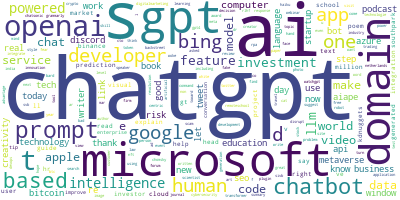

In [7]:
from wordcloud import WordCloud

# join the words of the different tweets together into one string
long_string = ' '.join(unique_tweets)
new_long_string = ' '.join(set(long_string.split(" ")))

# create a WordCloud object
wordcloud = WordCloud(background_color="white", max_words=1000, contour_width=3, contour_color='steelblue')

# generate a word cloud
wordcloud.generate(new_long_string)

# visualize the word cloud
wordcloud.to_image()

---

# Topic Modelling

1. download the nltk stopwords.
2. use the gensim to do simple preprocess of sentences.
3. remove the stopwords in sentences.

In [8]:
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess

import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

stop_words = stopwords.words('english')

# Do you want to modify this by adding more stop words?
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])

def sent_to_words(sentences):
  for sentence in sentences:
    yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))

def remove_stopwords(texts):
  return [[word for word in simple_preprocess(str(doc)) 
    if word not in stop_words] for doc in texts]


data = tweets_df.text_processed.values.tolist()

data_words = list(sent_to_words(data))

# remove stop words
data_words = remove_stopwords(data_words)

# create a dictionary
id2word = corpora.Dictionary(data_words)

# create a corpus
texts = data_words

# convert the corpus into a BoW representation
corpus = [id2word.doc2bow(text) for text in texts]


/Users/jiewang/opt/anaconda3/envs/dataEngineering/lib/python3.6/site-packages/scipy/sparse/sparsetools.py:21: DeprecationWarning: `scipy.sparse.sparsetools` is deprecated!
scipy.sparse.sparsetools is a private module for scipy.sparse, and should not be used.
  _deprecated()
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/jiewang/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [9]:
from pprint import pprint

# set number of topics
num_topics = 5

# build an LDA model
lda_model = gensim.models.LdaMulticore(corpus=corpus, id2word=id2word, num_topics=num_topics)

# print keywords in each topic
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.068*"chatgpt" + 0.014*"openai" + 0.013*"ai" + 0.009*"gpt" + 0.008*"data" '
  '+ 0.007*"new" + 0.007*"amp" + 0.006*"marketing" + 0.005*"strategy" + '
  '0.005*"corporate"'),
 (1,
  '0.069*"chatgpt" + 0.019*"ai" + 0.007*"like" + 0.006*"gpt" + 0.006*"chatbot" '
  '+ 0.005*"get" + 0.005*"microsoft" + 0.003*"one" + 0.003*"chatgptprompts" + '
  '0.003*"new"'),
 (2,
  '0.072*"chatgpt" + 0.028*"ai" + 0.008*"openai" + 0.006*"like" + 0.005*"new" '
  '+ 0.004*"chatbot" + 0.004*"week" + 0.004*"next" + 0.004*"gpt" + '
  '0.004*"amp"'),
 (3,
  '0.050*"ai" + 0.048*"chatgpt" + 0.007*"using" + 0.006*"like" + '
  '0.006*"openai" + 0.004*"amp" + 0.004*"tools" + 0.004*"via" + 0.004*"one" + '
  '0.004*"microsoft"'),
 (4,
  '0.059*"chatgpt" + 0.015*"ai" + 0.008*"new" + 0.005*"microsoft" + '
  '0.005*"gpt" + 0.004*"good" + 0.004*"first" + 0.003*"like" + 0.003*"bing" + '
  '0.003*"world"')]


# visualise the topics

1. set the data filepath.
2. save the data at the resources folder.
3. load the data file and generate the LDAvis.

In [10]:
import os
import pyLDAvis.gensim as gensimvis  #remind that pyLDAvis.gensim_models is newer one
import pickle 
import pyLDAvis

pyLDAvis.enable_notebook()

LDAvis_data_filepath = os.path.join('./resources/'+str(num_topics))

LDAvis_prepared = gensimvis.prepare(lda_model, corpus, id2word)
with open(LDAvis_data_filepath, 'wb') as f:
  pickle.dump(LDAvis_prepared, f)

with open(LDAvis_data_filepath, 'rb') as f:
  LDAvis_prepared = pickle.load(f)

pyLDAvis.save_html(LDAvis_prepared, './resources/'+ str(num_topics) +'.html')

LDAvis_prepared

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2      0.019680 -0.041285       1        1  22.297867
0      0.082456  0.069621       2        1  22.118415
1      0.027419 -0.051496       3        1  21.176328
3     -0.043611 -0.036040       4        1  19.249479
4     -0.085944  0.059201       5        1  15.157912, topic_info=              Term        Freq       Total Category  logprob  loglift
7               ai  476.000000  476.000000  Default  30.0000  30.0000
1412      strategy   23.000000   23.000000  Default  29.0000  29.0000
1452     readiness   21.000000   21.000000  Default  28.0000  28.0000
1451  incorporated   21.000000   21.000000  Default  27.0000  27.0000
1450    highlights   22.000000   22.000000  Default  26.0000  26.0000
...            ...         ...         ...      ...      ...      ...
68             amp    8.134950   79.329663   Topic5  -5.8779  -0.3908
14            time    5.953019   31.643744   Topic5  -6.1901   0.2160
15           tools    6.190898   38.195365   Topic5  -6.1510   0.0670
369          write    5.525431   32.570716   Topic5  -6.2647   0.1126
347           week    5.630724   42.109553   Topic5  -6.2458  -0.1254

[395 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
2558      4  0.783039     actions
4636      4  0.652510  adelahafez
7         1  0.251704          ai
7         2  0.113267          ai
7         3  0.159413          ai
...     ...       ...         ...
853       3  0.662355       years
853       4  0.147190       years
853       5  0.147190       years
1783      3  0.226378         yes
1783      5  0.679134         yes

[736 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 1, 2, 4, 5])

---

# Sentiment Analysis
# Task 1 What is the domiant sentiment towards large language models such as OpenAI's ChatGPT and others?

1. install the vaderSentiment.
2. use the analyzer.

In [45]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

# Initialize the analyzer
analyzer = SentimentIntensityAnalyzer()

# Create a dictionary for the results.
vsResults = {}

# Count for the dictionary
count = 0

for tweet_text in unique_tweets:
    vs = analyzer.polarity_scores(tweet_text)
    vsResults[count] = [tweet_text,vs]
    count += 1
#     print(tweet_text + '\t' + str(vs))

# The volumn of the tweets, equals to the variable count
volumn = count

# Just print to observe the results
for i in range(10):
    print(str(i)+":  ",str(vsResults[i][0])+"\t"+str(vsResults[i][1]))
    
# Create the dictionary of final result for four sentiments
sentimentResults = {'neg':0.0,'neu':0.0,'pos':0.0,'compound':0.0}
# Calculate the general sentiment of the tweets about chatgpt
for i in range(volumn):
    sentimentResults['neg'] += float(vsResults[i][1]['neg'])
    sentimentResults['neu'] += float(vsResults[i][1]['neu'])
    sentimentResults['pos'] += float(vsResults[i][1]['pos'])
    sentimentResults['compound'] += float(vsResults[i][1]['compound'])
    
print("\nThe main sentiment towards ChatGPT is: ",max(sentimentResults))

0:   three mile island has a clean-up cost that is higher than the construction cost of the plant itself #chatgpt	{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
1:   chatgpt prompts: your gateway to crafting unforgettable stories from mystery and suspense prompts to historical… 	{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
2:   there’s been a lot of chat about chatgpt in the press; we had a ‘virtual’ sit down with #chatgpt to find out how it… 	{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
3:   if you chatgpt isn't showing your recent history  don't panic  just logout to your account  again logged in and boo… 	{'neg': 0.0, 'neu': 0.875, 'pos': 0.125, 'compound': 0.4023}
4:   @crypto_bitlord7 are you tired of rugs  @zyteai got you  #zyte is building autonomous tools to help manage risk on… 	{'neg': 0.211, 'neu': 0.675, 'pos': 0.114, 'compound': -0.3182}
5:   hey @microsoft how about a @openai #chatgpt in a #googlehome or an #alexa - you can call it "mai"    you ar

---

# Named Entity Recognition

1. install the spacy.
2. load the nlp model.
3. get the result of nlp model.

In [4]:
import spacy
import en_core_web_trf

nlp = spacy.load('en_core_web_trf')

ModuleNotFoundError: No module named 'en_core_web_trf'

In [ ]:
for tweet_text in unique_tweets:
  doc = nlp(tweet_text)
  print(tweet_text)
  for ne in doc.ents:
    print('\tNE found: ', ne.start_char, ne.end_char, ne.label_, tweet_text[ne.start_char:ne.end_char])

---

# Named Entity Linking

This implementation is based on [spaCy Entity Linker](https://github.com/egerber/spacy-entity-linker).

In [ ]:
# !pip install spacy-entity-linker
# !python -m spacy download en_core_web_md

import en_core_web_md
from spacy.language import Language

In [ ]:
from spacy_entity_linker import EntityLinker

# !python -m spacy_entity_linker "download_knowledge_base"

nlp = spacy.load("en_core_web_md")

#add to pipeline
nlp.add_pipe('entityLinker', last=True)

In [ ]:
for tweet_text in unique_tweets:
  try:
    doc = nlp(tweet_text)
    print(tweet_text)
    all_linked_entities = doc._.linkedEntities
    for linked_entity in all_linked_entities:
      print(linked_entity.get_url() + ' ' + linked_entity.pretty_string(True))
  except:
    pass


---

# Task 2 What are the pros and cons of these large language models?

1. Use some grammatical formats for searching the pros and cons
2. Generate the pros and cons by searching with the use of some certain grammatical formats
3. Data clean for the outputs of pros and cons

### 1. Use some grammatical formats for searching the pros and cons

In [ ]:
# some shortcomings that should be improved: ignore the adv words after verbs

def find_prosandcons(results, pog_sentence):

    doc = nlp(pog_sentence)
    for token in doc:
        if token.pos_ == 'VERB':
            dependents = token.children
            for d in dependents:

                token_text = token.text

                if d.dep_ == 'prep':
                    token_text = token_text + ' ' + d.text
                    for pobjs in d.children:
                        if pobjs.dep_ == 'pobj':
                            token_text = token_text + ' ' + find_d_p_obj(pobjs)
                    
                    if len(token_text.split(' ')) >= 3:
                        results.append(token_text)

                elif d.dep_ == 'agent':
                    token_text = token_text + ' ' + d.text
                    for pobjs in d.children:
                        if pobjs.dep_ == 'pobj':
                            token_text = token_text + ' ' + find_d_p_obj(pobjs)
                    if len(token_text.split(' ')) >= 3:
                        results.append(token_text)

                elif d.dep_ == 'dobj':
                    token_text = token_text + ' ' + find_d_p_obj(d)
                    for preps in d.children:
                        if preps.dep_ == 'prep':
                            token_text = token_text + ' ' + preps.text
                            for pobjs in preps.children:
                                if pobjs.dep_ == 'pobj':
                                    token_text = token_text + ' ' + find_d_p_obj(pobjs)
                    if len(token_text.split(' ')) >= 3:
                        results.append(token_text)
                
                elif d.dep_ == 'acomp':
                    token_text = token_text + ' ' + d.text
                    for preps in d.children:
                        if preps.dep_ == 'prep':
                            token_text = token_text + ' ' + preps.text
                            for pobjs in preps.children:
                                if pobjs.dep_ == 'pobj':
                                    token_text = token_text + ' ' + find_d_p_obj(pobjs)
                    if len(token_text.split(' ')) >= 3:
                        results.append(token_text)
        
        if token.pos_ == 'ADJ':
            dependents = token.children
            for d in dependents:

                token_text = token.text

                if d.dep_ == 'prep':
                    token_text = token_text + ' ' + d.text
                    for pcomps in d.children:
                        if pcomps.dep_ == 'pcomp':
                            token_text = token_text + ' ' + pcomps.text
                            for advmods in pcomps.children:
                                if advmods.dep_ == 'advmod':
                                    token_text = token_text + ' ' + advmods.text
                    if len(token_text.split(' ')) >= 3:
                        results.append(token_text)
    
    return results
    
    # print(results)

    # for token in doc:
    #     print(token.text + '\t' + token.lemma_ + '\t' + token.pos_ + '\t' + token.tag_ + '\t' + token.dep_ + '\t' + str([child.text + ':' + child.dep_ for child in token.children]))

def find_d_p_obj(pobjs):
    amod_text = ''
    for d in pobjs.children:

        if d.dep_ == 'det':
            amod_text = amod_text + d.text + ' '

        elif d.dep_ == 'amod':
            amod_text = amod_text + d.text + ' '
    
    token_text = amod_text + pobjs.text

    return token_text

# find_prosandcons([], unique_tweets[173])

### 2. Generate the pros and cons by searching with the use of some certain grammatical formats

In [ ]:
pros = []
cons = []

for index, tweet_text in enumerate(unique_tweets):
    vs = analyzer.polarity_scores(tweet_text)
    neg, neu, pos, compound = vs['neg'], vs['neu'], vs['pos'], vs['compound']
    if compound > 0.1: # and pos >= neu and pos >= compound
        # print(index, tweet_text)
        pros = find_prosandcons(pros, tweet_text)
    if compound < -0.4: # 
        cons = find_prosandcons(cons, tweet_text)

# print(pros)
# print(cons)

### 3. Data clean for the outputs of pros and cons

In [ ]:

# 1: remove the pharses which ends up with 'a', 'an', 'it', ...
# 2: remove the pharses having fewer than 3 words, which has been done in the function find_prosandcons()

ends_up_words = ['%', '+', 'in', 'it', 'vc', '#', 'a', 'an', 'the', 'lil', 're', 'se', 'lm', 'ep', 'ch', 'e(|x|', 'f(x', '∞', 'sta', '=']

for i in range(10): # ends up with numbers
    ends_up_words.append(str(i))

upperletters = [chr(i) for i in range(65, 91)] # ends up with upperletters
lowerletters = [chr(i) for i in range(97, 123)] # ends up with lowerletters

for i in range(26):
    ends_up_words.append(upperletters[i])
    ends_up_words.append(lowerletters[i])

print(ends_up_words)

pros_results = []
cons_results = []

for pharse in pros:
    
    if pharse.split(' ')[-1] not in ends_up_words:
        pros_results.append(pharse)

for pharse in cons:
    
    if pharse.split(' ')[-1] not in ends_up_words:
        cons_results.append(pharse)

# for i in pros_results:
#     print(i)

# for i in cons_results:
#     print(i)


---

# Task 3 What fields will chatgpt be most useful in the future?

1. give a list of words which are relevant to the ability of doing something in the future
2. seize the postive sentiment sentences and lanuch the tokenization to them
3. use the nlp processor to find the initial form of future words and every positive sentence
4. find the Nouns which appears most frequently in these sentences containing future words

### 1. give a list of words which are relevant to the ability of doing something in the future

In [ ]:
future_words_origin = 'future prosperous prosperity can could better performance useful available futural improvement enhancement scale development evolve evolution improve predict will would beneficial impact effect influence intelligent intellectualisation'
future_words = []


for token in nlp(future_words_origin):
    # print(token.text + '\t' + token.lemma_ + '\t' + token.pos_ + '\t' + token.tag_ + '\t' + token.dep_ + '\t' + str([child.text + ':' + child.dep_ for child in token.children]))
    future_words.append(token.lemma_)

print(future_words)

 ### 2. seize the postive sentiment sentences and lanuch the tokenization to them
 ### 3. use the nlp processor to find the initial form of future words and every positive sentence
 ### 4. find the Nouns which appears most frequently in these sentences containing future words

In [ ]:
future_noun_words = {}

def frequences(dict, word):
    if word in dict.keys():
        dict[word] += 1
    else:
        dict[word] = 1

# chatgpt is defintely in the final results, and defintely should be removed
def useful_words(word):
    if word not in ends_up_words and word not in stop_words and word[0] != '@' and word not in future_words and word != 'chatgpt':
        return True
    else:
        return False

for index, tweet_text in enumerate(unique_tweets):
    vs = analyzer.polarity_scores(tweet_text)
    neg, neu, pos, compound = vs['neg'], vs['neu'], vs['pos'], vs['compound']
    if compound > 0.1: # and pos >= neu and pos >= compound
        # print(index, tweet_text)
        tweet_text_token = nlp(tweet_text)
        for token in tweet_text_token:
            if token.lemma_ in future_words:
                for nouns in tweet_text_token:
                    if nouns.pos_ == 'NOUN' and useful_words(nouns.lemma_):
                        frequences(future_noun_words, nouns.lemma_)
                break

future_noun_words = sorted(future_noun_words.items(), key=lambda item:item[1], reverse = True)

print(future_noun_words)


---